# Import Requirements

In [0]:
# import modules
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

# connecting to google Drive
from google.colab import drive
drive.mount('/content/gdrive')
warnings.filterwarnings('ignore')

In [0]:
!pip install catboost
!pip install shap

In [0]:
# Import libraries
from catboost import CatBoostRegressor
import shap

# Create DB with extra features **collected from feedbacks**

In [0]:
# read the PAP dataset
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/caraccess_PIP/csv_pap.csv')

In [0]:
# cut proba and decision columns
col = df[['proba', 'decision']]
df = df.drop(['proba', 'decision'], axis=1)

In [0]:
for i in range(df.shape[0]):
  if (df.view[i]=='luxe'):
    # feedback 1 : car thefts (https://www.stolencars24.eu/fr/stat.php?chart=1)
    df.at[i,'theft'] = np.random.choice(['probable', 'improbable'], p=[0.1, 0.9])
    # feedback 2 : add accidents (https://www.forbes.com/sites/jimgorzelany/2019/05/14/fatal-attraction-these-are-the-deadliest-cars-on-the-road)
    df.at[i,'accident'] = np.random.choice(['probable', 'improbable'], p=[0.1, 0.9])
    # feedback 3 : max speed exceeded ? based on car sensors
    df.at[i,'max speed'] = np.random.choice(['yes', 'no'], p=[0.9, 0.1])
    # feedback 4 : dangerous places visited ? based on GPS
    df.at[i,'bad places'] = np.random.choice(['yes', 'no'], p=[0.1, 0.9])
    # feedback 5 : auto pilot usage
    df.at[i,'auto pilot'] = np.random.choice(['never', 'sometimes', 'always'], p=[0.1, 0.2, 0.7])
  elif (df.view[i]=='normal'):
    df.at[i,'theft'] = np.random.choice(['probable', 'improbable'], p=[0.9, 0.1])
    df.at[i,'accident'] = np.random.choice(['probable', 'improbable'], p=[0.9, 0.1])
    df.at[i,'max speed'] = np.random.choice(['yes', 'no'], p=[0.1, 0.9])
    df.at[i,'bad places'] = np.random.choice(['yes', 'no'], p=[0.9, 0.1])
    df.at[i,'auto pilot'] = np.random.choice(['never', 'sometimes', 'always'], p=[0.7, 0.2, 0.1])
  else :
    df.at[i,'theft'] = np.random.choice(['probable', 'improbable'], p=[0.5, 0.5])
    df.at[i,'accident'] = np.random.choice(['probable', 'improbable'], p=[0.5, 0.5])
    df.at[i,'max speed'] = np.random.choice(['yes', 'no'], p=[0.5, 0.5])
    df.at[i,'bad places'] = np.random.choice(['yes', 'no'], p=[0.5, 0.5])
    df.at[i,'auto pilot'] = np.random.choice(['never', 'sometimes', 'always'], p=[0.3, 0.4, 0.3])

for i in range(df.shape[0]):
  # feedback 6 : checkout deadline missed ?
  df.at[i,'delay'] = np.random.choice(['yes', 'no'], p=[0.5, 0.5])
  # feedback 7 : max speed exceeded ? based on car sensors
  df.at[i,'max km'] = np.random.choice(['yes', 'no'], p=[0.5, 0.5])
  # feedback 8 : road signs respected ? based on car sensors
  df.at[i,'respect road signs'] = np.random.choice(['yes', 'no'], p=[0.5, 0.5])
  # feedback 9 : weather, based on car sensors
  df.at[i,'weather'] = np.random.choice(['sunny', 'rainy', 'cloudy', 'windy', 'stormy'])

In [0]:
df = pd.concat([df, col], axis=1)

In [49]:
df.sample(5)

,org,role,view,activity,context,theft,accident,max speed,bad places,auto pilot,delay,max km,respect road signs,weather,proba,decision
380,BA ORN,h BJS,DPY,JG54,LNHZ,improbable,probable,no,no,sometimes,yes,yes,no,windy,0.69,permitted
112,CD MRG,d WMF,HWV,KX81,LNXN,improbable,improbable,no,no,sometimes,no,no,yes,cloudy,0.77,permitted
214,others,blacklisted,luxe,a2,off,improbable,improbable,yes,no,sometimes,yes,no,yes,windy,0.81,denied
118,HQ AGV,b AIA,SCA,HT09,EECL,improbable,improbable,yes,no,never,yes,no,no,stormy,0.78,permitted
989,ZL WDN,f PDB,SCT,ZF51,YZCH,improbable,probable,no,yes,sometimes,no,yes,yes,stormy,0.94,permitted


In [0]:
# save prediction file without post processing
df.to_csv('pap_extraF.csv', index = False)
%cp pap_extraF.csv gdrive/'My Drive'/'Colab Notebooks'/'caraccess_PIP'

# Use the PAP extra dataset and catboost to analyze feature importance



In [58]:
# read the PAP extra dataset
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/caraccess_PIP/pap_extraF.csv')
df.sample(2)

,org,role,view,activity,context,theft,accident,max speed,bad places,auto pilot,delay,max km,respect road signs,weather,proba,decision
369,WI PFQ,p JVX,HGS,GU60,GGDI,probable,improbable,yes,no,always,yes,no,yes,windy,0.29,permitted
41,others,blacklisted,luxe,a1,peak,improbable,improbable,yes,no,always,no,yes,no,sunny,0.01,denied


In [0]:
# Split features and labels
y = df['proba']
X = df.drop(['proba', 'decision'], axis=1)

In [0]:
# list of categorical features
lst = list(np.arange(0, X.shape[1]))

In [0]:
# catboost initiation and training
catreg = CatBoostRegressor(iterations=1000, depth=6)
catreg.fit(X, y, cat_features=lst, verbose=0)

In [0]:
shap.initjs()
shap.dependence_plot('view', shap_values, X)

In [0]:
# Initialize your colab notebook with initjs(), otherwise you will get an error message.
shap.initjs()
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(catreg)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
i = 0
shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:])

In [0]:
shap.initjs()

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

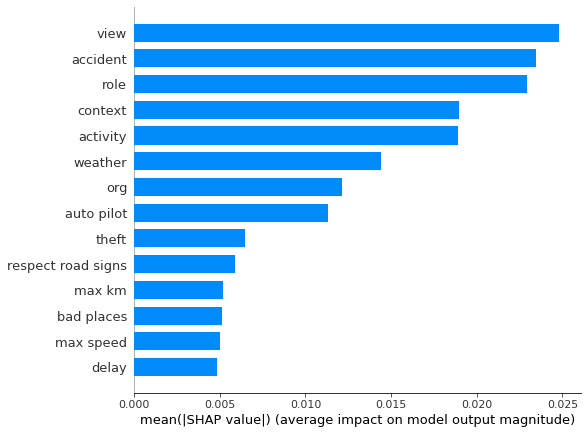

In [0]:
shap.initjs()
# visualize feature importance
shap.summary_plot(shap_values, X, plot_type="bar")